In [1]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
home_dir = "/user_data/heesok/MLSP/MLSP_Fall25_Project"
out_dir = os.path.join(home_dir,'figures')

In [8]:
#get audio files
gt_folder = os.path.join(home_dir,'data')
nmf_folder = os.path.join(home_dir,'output/NMF')
ica_folder = os.path.join(home_dir,'output/ICA')

gt_files = sorted([
    f for f in os.listdir(gt_folder)
    if f.lower().endswith(('.wav', '.mp3')) and "trimmed" in f.lower()
])
gt_vocal = [f for f in gt_files if "vocal" in f.lower()]
gt_inst  = [f for f in gt_files if "inst" in f.lower()]

# get "vocal" and "inst" for each 
def get_matching_files(gt_list, nmf_folder, ica_folder):
    nmf_files, ica_files = [], []
    for f in gt_list:
        base_name = f.replace("_trimmed", "")
        base_name = base_name.replace(".wav", "")
        nmf_match = [n for n in os.listdir(nmf_folder) if base_name in n]
        ica_match = [i for i in os.listdir(ica_folder) if base_name in i]
        if nmf_match and ica_match:
            nmf_files.append(sorted(nmf_match)[0])
            ica_files.append(sorted(ica_match)[0])
    return gt_list, nmf_files, ica_files

gt_vocal, nmf_vocal, ica_vocal = get_matching_files(gt_vocal, nmf_folder, ica_folder)
gt_inst, nmf_inst, ica_inst    = get_matching_files(gt_inst, nmf_folder, ica_folder)

gt_paths  = [os.path.join(gt_folder, gt_vocal[0]), os.path.join(gt_folder, gt_inst[0])]
nmf_paths = [os.path.join(nmf_folder, nmf_vocal[0]), os.path.join(nmf_folder, nmf_inst[0])]
ica_paths = [os.path.join(ica_folder, ica_vocal[0]), os.path.join(ica_folder, ica_inst[0])]

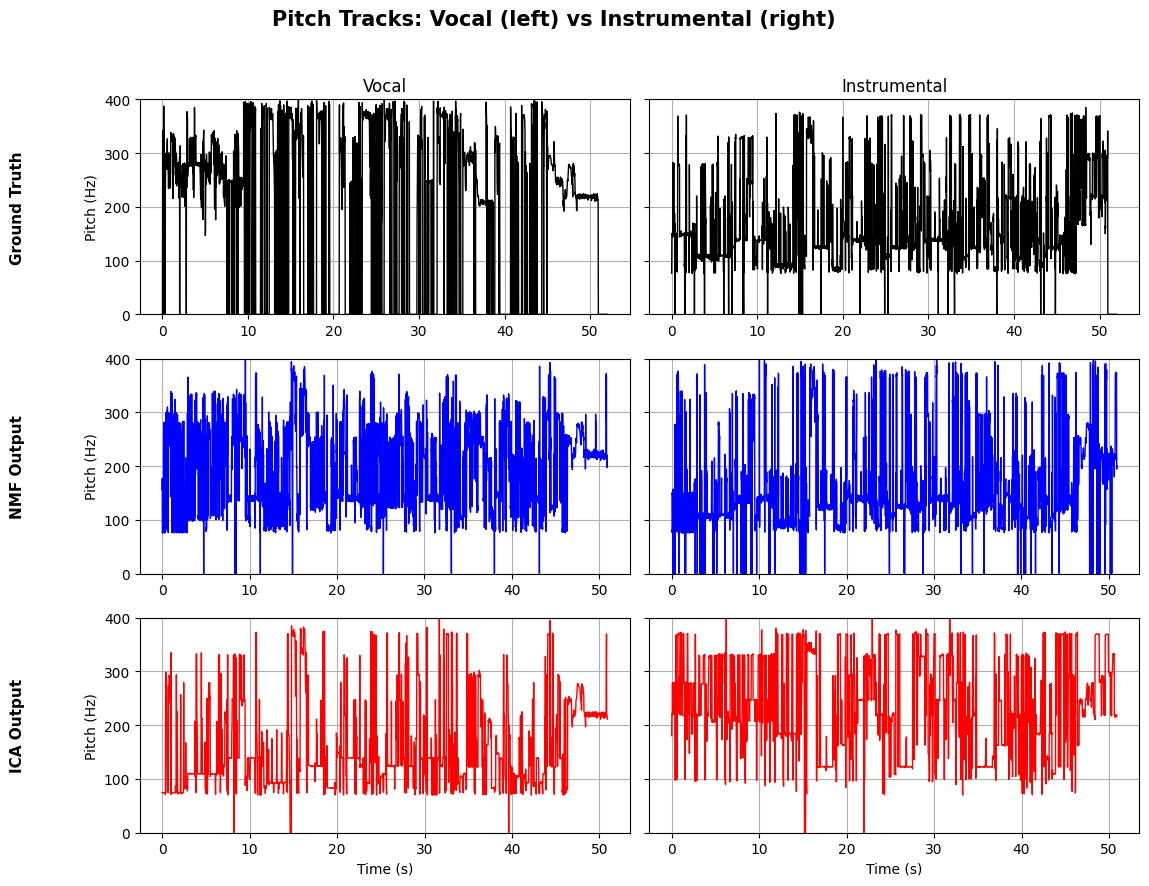

Vocal | Cosine similarity: GT–NMF=0.775, GT–ICA=0.717
Instrumental | Cosine similarity: GT–NMF=0.853, GT–ICA=0.842


In [9]:
def extract_pitch_track(audio_path, fmin=75, fmax=400):
    """Return pitch track (Hz) and time axis for a given audio file."""
    y, sr = librosa.load(audio_path, sr=None)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr, fmin=fmin, fmax=fmax)
    max_idx = np.argmax(magnitudes, axis=0)
    pitch_track = pitches[max_idx, range(magnitudes.shape[1])]
    times = librosa.times_like(pitch_track, sr=sr)
    return times, pitch_track

#for cos sim
pitch_tracks = {"GROUND": [], "NMF": [], "ICA": []}

# plot pitch comparisons:
categories = ["Vocal", "Instrumental"]
# plotting
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

row_labels = ["Ground Truth", "NMF Output", "ICA Output"]
colors = ["k", "b", "r"]

for row, (label, paths, color) in enumerate(zip(row_labels,
                                                [gt_paths, nmf_paths, ica_paths],
                                                colors)):
    for col, path in enumerate(paths):
        times, pitch_track = extract_pitch_track(path)
        pitch_track = np.nan_to_num(pitch_track)
        pitch_tracks[label.split()[0].upper()].append(pitch_track)
        ax = axes[row, col]
        ax.plot(times, pitch_track, color=color, lw=1)
        ax.set_ylim(0, 400)
        ax.grid(True)
        if row == 2:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("Pitch (Hz)")
        if row == 0:
            ax.set_title(categories[col])

# row labels on the left
for ax, label in zip(axes[:, 0], row_labels):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords='axes fraction',
                ha='center', va='center', rotation=90, fontsize=11, weight='bold')

fig.suptitle("Pitch Tracks: Vocal (left) vs Instrumental (right)", fontsize=15, weight='bold')
plt.tight_layout(rect=[0.05, 0, 1, 0.96])
plt.savefig(os.path.join(out_dir,"pitch_tracks_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

for col, source_type in enumerate(categories):
    gt = pitch_tracks["GROUND"][col]
    nmf = pitch_tracks["NMF"][col]
    ica = pitch_tracks["ICA"][col]

    min_len = min(len(gt), len(nmf), len(ica))
    gt, nmf, ica = gt[:min_len], nmf[:min_len], ica[:min_len]

    cos_nmf = cosine_similarity(gt.reshape(1, -1), nmf.reshape(1, -1))[0, 0]
    cos_ica = cosine_similarity(gt.reshape(1, -1), ica.reshape(1, -1))[0, 0]

    print(f"{source_type} | Cosine similarity: GT–NMF={cos_nmf:.3f}, GT–ICA={cos_ica:.3f}")

/tmp/ipykernel_1029806/1685906723.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])


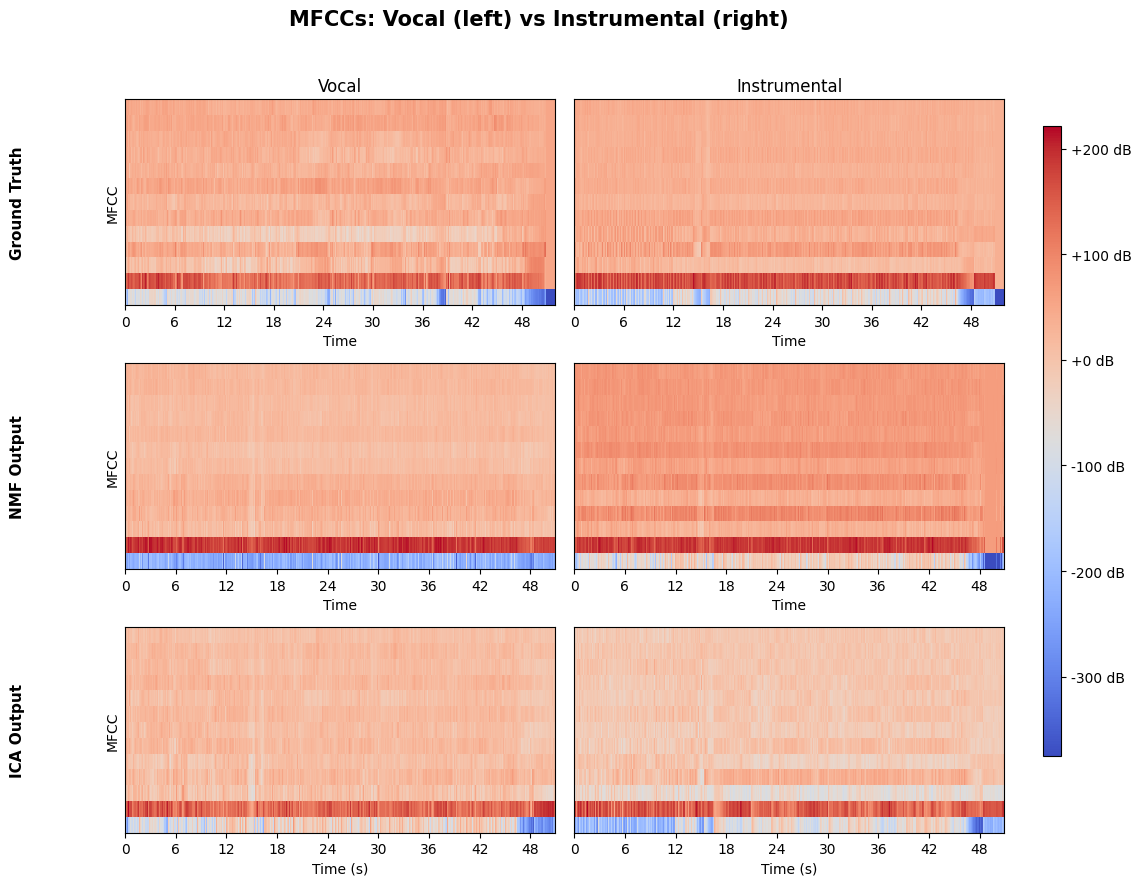

Vocal: GT–NMF = 0.7977, GT–ICA = 0.6049
Instrumental: GT–NMF = 0.9391, GT–ICA = 0.8316


In [14]:
# plot MFCC comparison:
#for cos sim
MFCCS = {"GROUND": [], "NMF": [], "ICA": []}

categories = ["Vocal", "Instrumental"]
row_labels = ["Ground Truth", "NMF Output", "ICA Output"]

# plotting:
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

for row, (label, paths) in enumerate(zip(row_labels, [gt_paths, nmf_paths, ica_paths])):
    for col, path in enumerate(paths):
        y, sr = librosa.load(path, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        MFCCS[label.split()[0].upper()].append(mfccs)
        ax = axes[row, col]
        img = librosa.display.specshow(mfccs, x_axis="time", ax=ax, sr=sr)
        ax.set_title(categories[col] if row == 0 else "")
        if row == 2:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("MFCC")
        ax.grid(False)

# row labels on the left
for ax, label in zip(axes[:, 0], row_labels):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords='axes fraction',
                ha='center', va='center', rotation=90, fontsize=11, weight='bold')

fig.suptitle("MFCCs: Vocal (left) vs Instrumental (right)", fontsize=15, weight='bold')
# color bar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])
plt.savefig(os.path.join(out_dir,"MFCCs_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

#mfcc frame specific cosine similarity
def mfcc_cosine_similarity(mfcc_gt, mfcc_est):
    n_frames = min(mfcc_gt.shape[1], mfcc_est.shape[1])
    cos_vals = []
    for i in range(n_frames):
        cos = cosine_similarity(mfcc_gt[:, i].reshape(1, -1),
                                mfcc_est[:, i].reshape(1, -1))[0, 0]
        cos_vals.append(cos)
    return np.mean(cos_vals), np.std(cos_vals)

for col, source_type in enumerate(categories):
    gt = MFCCS["GROUND"][col]
    nmf = MFCCS["NMF"][col]
    ica = MFCCS["ICA"][col]

    cos_nmf,_ = mfcc_cosine_similarity(gt, nmf)
    cos_ica,_ = mfcc_cosine_similarity(gt, ica)


    print(f"{source_type}: GT–NMF = {cos_nmf:.4f}, GT–ICA = {cos_ica:.4f}")

/tmp/ipykernel_1029806/631085847.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])


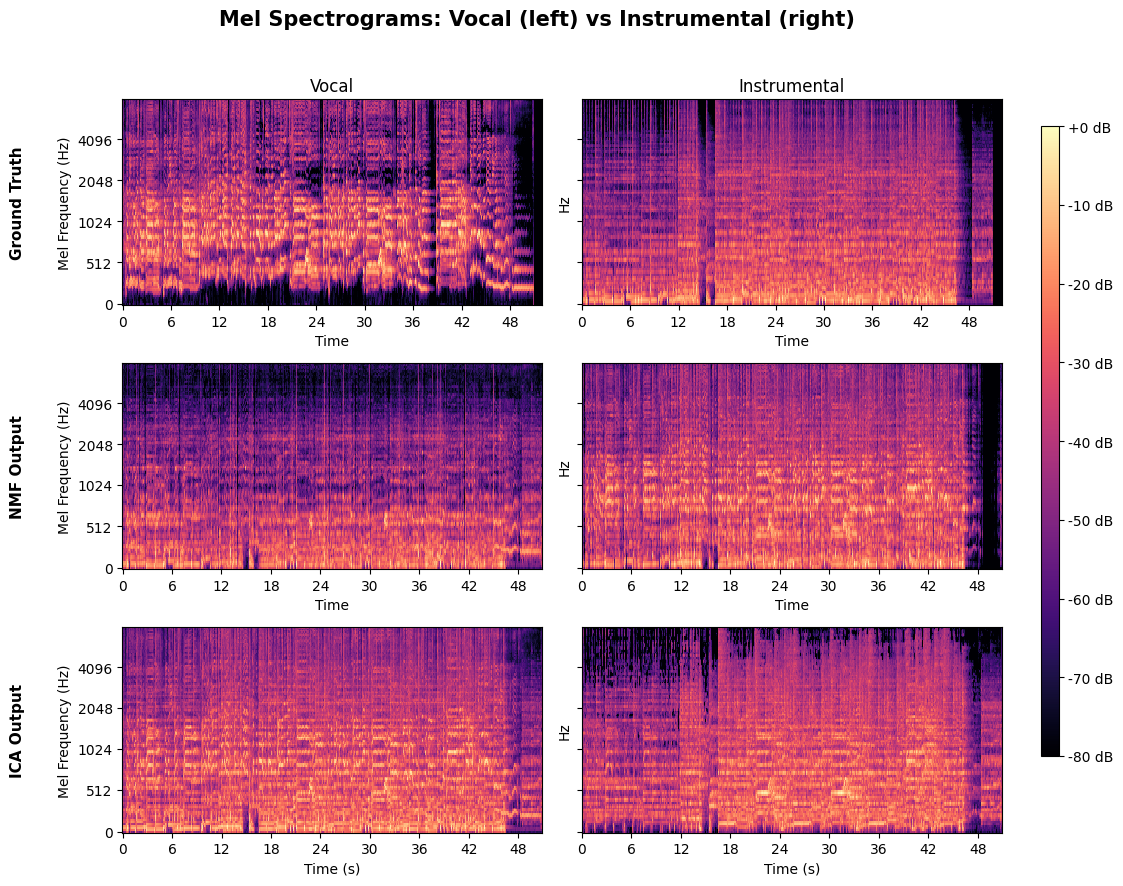

Vocal: GT–NMF = 0.9238, GT–ICA = 0.9210
Instrumental: GT–NMF = 0.9719, GT–ICA = 0.9484


In [12]:
# Mel Spectrograms:
#for cosine sim
MELS = {"GROUND": [], "NMF": [], "ICA": []}

categories = ["Vocal", "Instrumental"]
row_labels = ["Ground Truth", "NMF Output", "ICA Output"]

fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0.4, wspace=0.25)

for row, (label, paths) in enumerate(zip(row_labels, [gt_paths, nmf_paths, ica_paths])):
    for col, path in enumerate(paths):
        y, sr = librosa.load(path, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000) # mel spec
        S_dB = librosa.power_to_db(S, ref=np.max) # to dB
        MELS[label.split()[0].upper()].append(S_dB)
        ax = axes[row, col]
        img = librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sr, fmax=8000, ax=ax)
        ax.set_title(categories[col] if row == 0 else "")
        if row == 2:
            ax.set_xlabel("Time (s)")
        if col == 0:
            ax.set_ylabel("Mel Frequency (Hz)")
        ax.grid(False)


for ax, label in zip(axes[:, 0], row_labels):
    ax.annotate(label, xy=(-0.25, 0.5), xycoords='axes fraction',
                ha='center', va='center', rotation=90, fontsize=11, weight='bold')

fig.suptitle("Mel Spectrograms: Vocal (left) vs Instrumental (right)", fontsize=15, weight='bold')
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(img, cax=cbar_ax, format='%+2.0f dB')

plt.tight_layout(rect=[0.05, 0, 0.9, 0.96])
plt.savefig(os.path.join(out_dir,"MelSpecs_compare_to_GT.png"), dpi=300, bbox_inches="tight")
plt.show()

for col, source_type in enumerate(categories):
    gt = MELS["GROUND"][col]
    nmf = MELS["NMF"][col]
    ica = MELS["ICA"][col]

    # flatten!!
    min_frames = min(gt.shape[1], nmf.shape[1], ica.shape[1])
    gt_f = gt[:, :min_frames].flatten()
    nmf_f = nmf[:, :min_frames].flatten()
    ica_f = ica[:, :min_frames].flatten()

    cos_nmf = cosine_similarity(gt_f.reshape(1, -1), nmf_f.reshape(1, -1))[0, 0]
    cos_ica = cosine_similarity(gt_f.reshape(1, -1), ica_f.reshape(1, -1))[0, 0]

    print(f"{source_type}: GT–NMF = {cos_nmf:.4f}, GT–ICA = {cos_ica:.4f}")